In [1]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import preprocess_string
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess


In [2]:
pd.set_option("display.max_colwidth", 900)
msg=pd.read_csv('data_ch5/twitter-airline/Tweets.csv', usecols=['text'])

In [30]:
msg.head(20)

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials to the experience... tacky.
2,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,@VirginAmerica and it's a really big bad thing about it
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


clean up text, including emojis

In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')  
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    text=text.encode('ascii', 'ignore').decode('ascii')  #remove any emoji
    return text

In [4]:
import re

HANDLE = '@\w+'
LINK = 'https?://t\.co/\w+'
SPECIAL_CHARS = '&lt;|&lt;|&amp;|#'
def clean(text):
    text = re.sub(HANDLE, ' ', text)
    text = re.sub(LINK, ' ', text)
    text = re.sub(SPECIAL_CHARS, ' ', text)
    return text



In [5]:
msg['text']=msg['text'].apply(clean)

In [6]:
msg[70:85]

,text
70,Need to change reservation. Have Virgin credit card. Do I need to modify on phone to waive change fee? Or can I do online?
71,I emailed your customer service team. Let me know if you need the tracking number.
72,"hi I just booked a flight but need to add baggage, how can I do this?"
73,your airline is awesome but your lax loft needs to step up its game. $40 for dirty tables and floors?
74,"not worried, it's been a great ride in a new plane with great crew. All airlines should be like this."
75,awesome. I flew yall Sat morning. Any way we can correct my bill ?
76,"Or watch some of the best student films in the country at 35,000 feet! CMFat35000feet"
77,first time flying you all. do you have a different rate/policy for media Bags? Thanks
78,what is going on with customer service? Is there anyway to speak to a human asap? Thank you.
79,what happened to Doom?!


After cleaning text, we are ready to use the gensim library to build model. We have to convert the text data into the form 
required for gensim. The gensim LDA model requires the data to be the lists, meaning each entry in the list is a list of tokens that makeup each indiviual document.

In [8]:
msg=msg.text.apply(preprocess_string).tolist()
dictionary=corpora.Dictionary(msg)
corpus=[dictionary.doc2bow(text) for text in msg]

In [9]:
dictionary

In [10]:
corpus

[[(0, 1)],
 [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(6, 1), (7, 1), (8, 1), (9, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)],
 [(18, 1), (19, 1), (20, 1)],
 [(18, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)],
 [(22, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)],
 [(34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)],
 [(40, 1)],
 [(41, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)],
 [(53, 1), (54, 1), (55, 1), (56, 1), (57, 1)],
 [(9, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)],
 [(22, 1), (27, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)],
 [(68, 1)],
 [(69, 1), (70, 1), (71, 1), (72, 1)],
 [(20, 1),
  (21, 1),
  (60, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1)],
 [(25, 1),
  (72, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1)

In [36]:
num_topics=10
ldamodel=LdaModel(corpus, num_topics, id2word=dictionary, passes=15)

In [37]:
ldamodel.print_topics(num_words=6)

[(0,
  '0.045*"ticket" + 0.031*"thank" + 0.022*"respons" + 0.019*"love" + 0.018*"appreci" + 0.018*"gui"'),
 (1,
  '0.043*"servic" + 0.042*"custom" + 0.038*"hold" + 0.036*"help" + 0.031*"agent" + 0.030*"hour"'),
 (2,
  '0.048*"seat" + 0.038*"look" + 0.024*"flight" + 0.021*"like" + 0.019*"trip" + 0.018*"go"'),
 (3,
  '0.074*"thank" + 0.039*"airlin" + 0.030*"servic" + 0.028*"custom" + 0.020*"worst" + 0.020*"fly"'),
 (4,
  '0.180*"flight" + 0.073*"cancel" + 0.037*"flightl" + 0.029*"help" + 0.026*"tomorrow" + 0.023*"need"'),
 (5,
  '0.039*"bag" + 0.032*"flight" + 0.031*"thank" + 0.022*"great" + 0.018*"baggag" + 0.018*"ye"'),
 (6,
  '0.049*"plane" + 0.047*"flight" + 0.041*"hour" + 0.040*"wait" + 0.023*"sit" + 0.022*"delai"'),
 (7,
  '0.030*"follow" + 0.025*"american" + 0.018*"check" + 0.017*"board" + 0.017*"respond" + 0.017*"pass"'),
 (8,
  '0.067*"flight" + 0.040*"delai" + 0.027*"late" + 0.023*"miss" + 0.020*"connect" + 0.018*"crew"'),
 (9,
  '0.037*"number" + 0.035*"email" + 0.023*"issu" +

In order to decide on the correct number of topics, we will need a way to assesses how ell the model's topics were chosen. Gensim provides CoherenceModel instance that you can use

In [39]:
def Coherence_score(doc, dic, mod):
    coh_model=CoherenceModel(model=mod, texts=doc, dictionary=dic, coherence='c_v')
    
    return coh_model.get_coherence()


def coherence_value(start, stop):
    for n in range(start, stop):
        print(f'\nCalculateing coherence for {n} topics')
        ldamodel=LdaModel(corpus, num_topics=n, id2word=dictionary, passes=2)
        coherence=Coherence_score(msg, dictionary, ldamodel)
        
        yield coherence

Create a list of the coherence scores from10-30 topics

In [41]:
min_topics, max_topics=10,30
coherence_score=list(coherence_value(min_topics, max_topics))


Calculateing coherence for 10 topics

Calculateing coherence for 11 topics

Calculateing coherence for 12 topics

Calculateing coherence for 13 topics

Calculateing coherence for 14 topics

Calculateing coherence for 15 topics

Calculateing coherence for 16 topics

Calculateing coherence for 17 topics

Calculateing coherence for 18 topics

Calculateing coherence for 19 topics

Calculateing coherence for 20 topics

Calculateing coherence for 21 topics

Calculateing coherence for 22 topics

Calculateing coherence for 23 topics

Calculateing coherence for 24 topics

Calculateing coherence for 25 topics

Calculateing coherence for 26 topics

Calculateing coherence for 27 topics

Calculateing coherence for 28 topics

Calculateing coherence for 29 topics


Plot the coherence scores

In [17]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from IPython.display import display
from matplotlib.ticker import MaxNLocator
%matplotlib inline

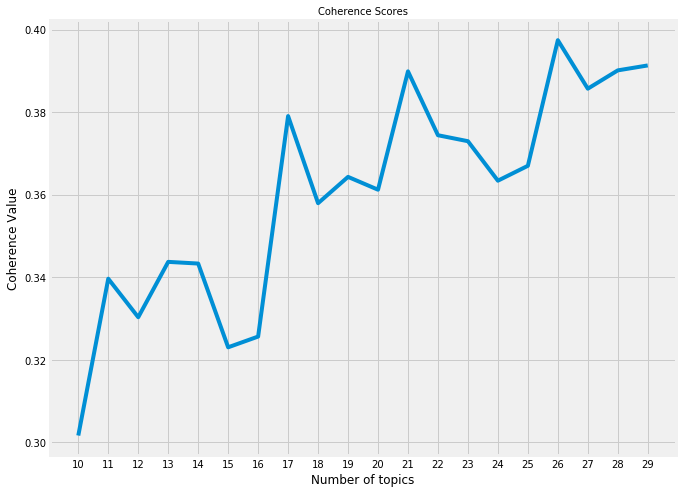

In [43]:
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator

style.use('fivethirtyeight')

%matplotlib inline

x = [int(i) for i in range(min_topics, max_topics)]

ax = plt.figure(figsize=(10,8))
plt.xticks(x)
plt.plot(x, coherence_score)
plt.xlabel('Number of topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores', fontsize=10);


# Topic fingerprinting
We will use of the LDA model to list the topics along with the scores for the document. Using these topics, we will create a vector, which then will be converted into a chart

Visualization Documents using Topic Vectors

In [2]:
pd.set_option("display.max_colwidth", 800)
open_data_url='data_ch5/canada-open-data/inventory.csv'
columns=['title_en','description_en','date_released']

In [3]:
catalog=pd.read_csv(open_data_url, usecols=columns)
catalog=catalog.dropna(subset=['description_en'])

In [4]:
catalog

,title_en,description_en,date_released
0,The AAFC Productivity Account for Canadian Agriculture,"The AAFC Productivity Account for Canadian agriculture is an annual time-series database, covering the years 1961-2011, that is comprised of price index and constant dollar implicit quantity series for gross output and input aggregates. The data are defined at the national level only – i.e. for the whole of Canada. These data are used to estimate a total factor productivity (TFP) index for Canadian agriculture, which is the ratio of total gross output to total input, where both output and input are constant dollar implicit quantities. Average growth in the TFP index, referred to as TFP growth, can be estimated using a variety of methods; the growth rate reported in AAFC publications is estimated using OLS.\n\nFurther documentation provided in AAFC_PACA.odt",2018-08-10
1,Swift Current Water Chemistry - Long Term Tillage Study - 1962-2011,"The Swift current water quantity and quality is an annual time-series database covering the period of 1962-2011. This database contains datasets for annual runoff volume, peak flow rates, water quality attributes, snow water equivalent and soil moisture from an edge of field study conducted at Swift Current, SK.",2018-11-23
2,Minor Use Pesticides Program Project Status by Crop,"The Pest Management Centre’s (PMC) Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\n\nThis is a complete list of PMC’s projects with their statuses. For those projects with the status D.3.2 Review Complete, please check with the pesti...",2018-12-14
3,Minor Use Pesticides Program Submission Status by Fiscal Year,"The Pest Management Centre Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\n\nThis list of submissions to PMRA is the result of PMC’s work and is for information purposes only. To find out if the pesticide can be used, please check wi...",2018-12-14
4,Minor Use Pesticides Program Trial Statistics by Year by Discipline,The following table provides information pertaining to the minor use pesticide study and/or trial status. These studies/trials are managed by the Pest management Center of the AAFC. This table is updated monthly.,2018-12-14
5,"Land Cover for Agricultural Regions of Canada, circa 2000","The “Land Cover for Agricultural Regions of Canada, circa 2000” is a thematic land cover classification representative of Circa 2000 conditions for agricultural regions of Canada. Land cover is derived from Landsat5-TM and/or 7-ETM+ multi-spectral imagery by inputting imagery and ground reference training data into a Decision-Tree or Supervised image classification process. Object segmentation, pixel filtering, and/or post editing is applied as part of the image classification. Mapping is corrected to the GeoBase Data Alignment Layer. National Road Network (1:50,000) features and other select existing land cover produc

In [5]:
def text_to_tokens(text):
    text=text.lower()
    text=remove_stopwords(text)
    tokens=simple_preprocess(text)
    
    return tokens

In [6]:
dataset_descr=catalog.description_en.apply(text_to_tokens)

In [7]:
dataset_descr

0                                                                                                                                                                                                         [aafc, productivity, account, canadian, agriculture, annual, time, series, database, covering, years, comprised, price, index, constant, dollar, implicit, quantity, series, gross, output, input, aggregates, data, defined, national, level, canada, data, estimate, total, factor, productivity, tfp, index, canadian, agriculture, ratio, total, gross, output, total, input, output, input, constant, dollar, implicit, quantities, average, growth, tfp, index, referred, tfp, growth, estimated, variety, methods, growth, rate, reported, aafc, publications, estimated, ols, documentation, provided, aafc_paca, odt]
1                                                                                                                                                                                              

Now we will use LdaModel and also create two objects-a dictionary instance containing the tokens from dataset_descr and a corpus instance

In [8]:
dictionary=corpora.Dictionary(dataset_descr)
corpus=[dictionary.doc2bow(text) for text in dataset_descr]

# To get a sense of what us contained in dictionary, we can loop through the first 20 items
for i in range(0,20):
    print(i, dictionary[i])

0 aafc
1 aafc_paca
2 account
3 aggregates
4 agriculture
5 annual
6 average
7 canada
8 canadian
9 comprised
10 constant
11 covering
12 data
13 database
14 defined
15 documentation
16 dollar
17 estimate
18 estimated
19 factor


For four topic vectors, we will choose a vector size 50. This mean we will build a model with 50 topics

In [9]:
vector_size=50
lda_model:LdaModel=LdaModel(corpus, num_topics=vector_size, passes=4)
lda_model.num_topics    

50

The process of create topic vectors, for example the code below

In [10]:
text=catalog['description_en'][0]
tokens=text_to_tokens(text)
bow=dictionary.doc2bow(tokens)
pd.DataFrame(lda_model[bow], columns=['Topic','Relevance']).set_index("Topic")




,Relevance
Topic,
5,0.033188
6,0.169749
11,0.068362
12,0.046426
15,0.093020
18,0.082495
20,0.029466
22,0.134496
25,0.061552


Create function that take a text description and convert it into a vector with  50 items

In [24]:
def topic_vector(topic_model:LdaModel, text:str):
    processed_text=text_to_tokens(text)
    fingerprint=[0] * topic_model.num_topics
    
    for topic, prob in topic_model[dictionary.doc2bow(processed_text)]:
        
        fingerprint[topic]=prob
    
    return fingerprint

Create a image from a text description 

In [27]:
vector_size=50
def show_fingerprint(topic_model, text:str):
    
    display(text)
    vector=topic_vector(topic_model, text)
    plt.figure(figsize=(10,5))
    ax=plt.bar(range(len(vector)), vector, 0.25, linewidth=1)
    
    plt.ylim(top=0.4)
    plt.tick_params(axis='both', left=False, bottom=False,top=False, labelleft=True, labelbottom=True)
    plt.grid(False)

'The AAFC Productivity Account for Canadian agriculture is an annual time-series database, covering the years 1961-2011, that is comprised of price index and constant dollar implicit quantity series for gross output and input aggregates. The data are defined at the national level only – i.e. for the whole of Canada. These data are used to estimate a total factor productivity (TFP) index for Canadian agriculture, which is the ratio of total gross output to total input, where both output and input are constant dollar implicit quantities. Average growth in the TFP index, referred to as TFP growth, can be estimated using a variety of methods; the growth rate reported in AAFC publications is estimated using OLS.\n\nFurther documentation provided in AAFC_PACA.odt'

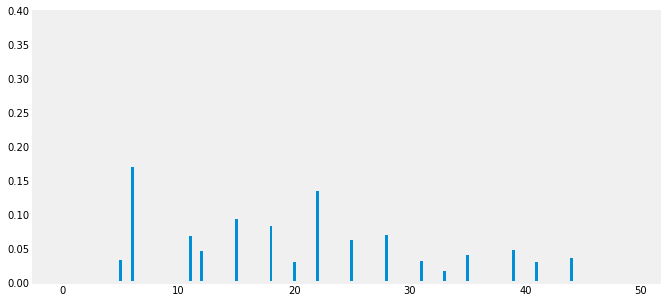

In [28]:
show_fingerprint(lda_model, catalog.description_en[0])

"The Pest Management Centre Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\n\nThis list of submissions to PMRA is the result of PMC’s work and is for information purposes only. To find out if the pesticide can be used, please check with the pesticide manufacturer or visit PMRA's pesticide label database. "

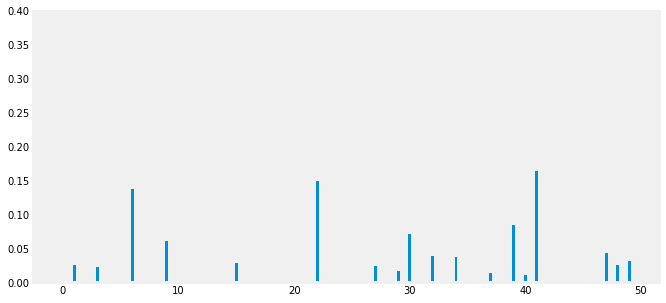

In [29]:
show_fingerprint(lda_model, catalog.description_en[3])